In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import model_selection
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)

In [3]:
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]
FEATURESALL_WTS = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType", "happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt"]

In [4]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu", "more-afraid_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma", "more-afraid_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
WTS_LABEL = ["happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt"]

In [5]:
mapper = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], None)], input_df = True)

In [6]:
transformedData = pd.DataFrame(mapper.fit_transform(data.copy()), columns=FEATURESALL)

In [7]:
transformedData["FFPType"] = transformedData["FFPType"].astype('int64')

In [8]:
WTS= {'happier_wt':(1.0-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.0-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.0-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values,
      'more-afraid_wt':(1.0-(scores[EMOCONFIDENCE_INV[3]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,transformedData.index)
transformedData_WTS = pd.concat([transformedData, WTS_df], axis = 1)

In [9]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(transformedData_WTS, scores, test_size=0.2, random_state=42)

In [10]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [11]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
one_hot_ffp = tf.feature_column.indicator_column(tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64))
sparse_ffp_column =  tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64)

# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")

feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, embedded_ffp_column]
#feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, one_hot_ffp]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime]
#lin_feature_cols = [sparse_ffp_column]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, sparse_ffp_column]
lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, sparse_ffp_column]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, one_hot_ffp]

In [12]:
LABEL_ID = 0;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [13]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
input_fn=get_input_fn(X_test, y_test, LABEL, num_epochs=1, shuffle=False),
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=500) #200 500 1000
    #metrics=validation_metrics)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


In [14]:
# Build a wide + deep model
model_dir_name="/DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001"
#model_dir_name="/DNNNew/DNNScared/scared_ConfidenceSoftPlus2Layer100_100UnitsDropout02EarlyStopLR001_8020Data_oneHot"

regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
   dnn_feature_columns=feature_cols, dnn_hidden_units=[10,10],  model_dir=model_dir_name, weight_column_name = WT_COL,
     dnn_optimizer = tf.train.AdamOptimizer(
       learning_rate=0.001), dnn_dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.softplus)

# regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, hidden_units=[100,100],  model_dir=model_dir_name, weight_column_name = WT_COL,
#     optimizer = tf.train.AdamOptimizer(
#       learning_rate=0.001), dropout =0.2, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), activation_fn = tf.nn.softplus)

#tf.contrib.layers.xavier_initializer(uniform=True) # this seems more useful for vision stuff where there is lot of fan_in and fan_out

Instructions for updating:
Please set fix_global_step_increment_bug=True and update training steps in your pipeline. See pydoc for details.
INFO:tensorflow:Using config: {'_model_dir': '/DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001', '_session_config': None, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_evaluation_master': '', '_task_type': None, '_master': '', '_log_step_count_steps': 100, '_num_worker_replicas': 0, '_save_checkpoints_secs': 1, '_is_chief': True, '_save_summary_steps': 100, '_task_id': 0, '_environment': 'local', '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000000EAE6D30>, '_num_ps_replicas': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
}


In [15]:
# Train.
regressor.fit(input_fn=get_input_fn(X_train, y_train, LABEL, num_epochs=None, shuffle=True),steps=200000, monitors=[validation_monitor]) #2000000

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 2 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:loss = 415.0, step = 2
INFO:tensorflow:Saving checkpoints for 4 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 6 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 8 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 10 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Savin

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-52
INFO:tensorflow:Finished evaluation at 2018-02-13-00:09:25
INFO:tensorflow:Saving dict for global step 52: global_step = 52, loss = 485.299
INFO:tensorflow:Validation (step 51): global_step = 52, loss = 485.299
INFO:tensorflow:Saving checkpoints for 54 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 56 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 58 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 60 into /DNNNew/DNNHappy/wideAndD

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-102
INFO:tensorflow:Finished evaluation at 2018-02-13-00:09:57
INFO:tensorflow:Saving dict for global step 102: global_step = 102, loss = 421.093
INFO:tensorflow:Validation (step 101): global_step = 102, loss = 421.093
INFO:tensorflow:Saving checkpoints for 104 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 106 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 108 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 110 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-152
INFO:tensorflow:Finished evaluation at 2018-02-13-00:10:30
INFO:tensorflow:Saving dict for global step 152: global_step = 152, loss = 365.818
INFO:tensorflow:Validation (step 151): global_step = 152, loss = 365.818
INFO:tensorflow:Saving checkpoints for 154 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 156 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 158 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 160 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-202
INFO:tensorflow:Finished evaluation at 2018-02-13-00:11:02
INFO:tensorflow:Saving dict for global step 202: global_step = 202, loss = 314.498
INFO:tensorflow:Validation (step 201): global_step = 202, loss = 314.498
INFO:tensorflow:loss = 175.254, step = 202 (116.361 sec)
INFO:tensorflow:Saving checkpoints for 204 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 206 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 208 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:te

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-252
INFO:tensorflow:Finished evaluation at 2018-02-13-00:11:35
INFO:tensorflow:Saving dict for global step 252: global_step = 252, loss = 262.582
INFO:tensorflow:Validation (step 251): global_step = 252, loss = 262.582
INFO:tensorflow:Saving checkpoints for 254 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 256 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 258 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 260 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-302
INFO:tensorflow:Finished evaluation at 2018-02-13-00:12:16
INFO:tensorflow:Saving dict for global step 302: global_step = 302, loss = 208.884
INFO:tensorflow:Validation (step 301): global_step = 302, loss = 208.884
INFO:tensorflow:Saving checkpoints for 304 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 306 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 308 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 310 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-352
INFO:tensorflow:Finished evaluation at 2018-02-13-00:12:50
INFO:tensorflow:Saving dict for global step 352: global_step = 352, loss = 154.142
INFO:tensorflow:Validation (step 351): global_step = 352, loss = 154.142
INFO:tensorflow:Saving checkpoints for 354 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 356 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 358 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 360 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-402
INFO:tensorflow:Finished evaluation at 2018-02-13-00:13:27
INFO:tensorflow:Saving dict for global step 402: global_step = 402, loss = 102.047
INFO:tensorflow:Validation (step 401): global_step = 402, loss = 102.047
INFO:tensorflow:loss = 59.1494, step = 402 (144.760 sec)
INFO:tensorflow:Saving checkpoints for 404 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 406 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 408 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:te

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-452
INFO:tensorflow:Finished evaluation at 2018-02-13-00:14:01
INFO:tensorflow:Saving dict for global step 452: global_step = 452, loss = 59.57
INFO:tensorflow:Validation (step 451): global_step = 452, loss = 59.57
INFO:tensorflow:Saving checkpoints for 454 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 456 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 458 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 462 into /DNNNew/DNNHappy/wid

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-502
INFO:tensorflow:Finished evaluation at 2018-02-13-00:14:35
INFO:tensorflow:Saving dict for global step 502: global_step = 502, loss = 33.5515
INFO:tensorflow:Validation (step 501): global_step = 502, loss = 33.5515
INFO:tensorflow:Saving checkpoints for 504 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 506 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 508 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 510 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-552
INFO:tensorflow:Finished evaluation at 2018-02-13-00:15:07
INFO:tensorflow:Saving dict for global step 552: global_step = 552, loss = 22.9535
INFO:tensorflow:Validation (step 551): global_step = 552, loss = 22.9535
INFO:tensorflow:Saving checkpoints for 554 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 556 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 558 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 560 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-602
INFO:tensorflow:Finished evaluation at 2018-02-13-00:15:41
INFO:tensorflow:Saving dict for global step 602: global_step = 602, loss = 19.1677
INFO:tensorflow:Validation (step 601): global_step = 602, loss = 19.1677
INFO:tensorflow:loss = 25.1316, step = 602 (134.698 sec)
INFO:tensorflow:Saving checkpoints for 604 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 606 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 608 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:te

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-652
INFO:tensorflow:Finished evaluation at 2018-02-13-00:16:15
INFO:tensorflow:Saving dict for global step 652: global_step = 652, loss = 17.3075
INFO:tensorflow:Validation (step 651): global_step = 652, loss = 17.3075
INFO:tensorflow:Saving checkpoints for 654 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 656 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 658 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 660 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-702
INFO:tensorflow:Finished evaluation at 2018-02-13-00:16:48
INFO:tensorflow:Saving dict for global step 702: global_step = 702, loss = 15.9941
INFO:tensorflow:Validation (step 701): global_step = 702, loss = 15.9941
INFO:tensorflow:Saving checkpoints for 704 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 706 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 708 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 710 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-752
INFO:tensorflow:Finished evaluation at 2018-02-13-00:17:24
INFO:tensorflow:Saving dict for global step 752: global_step = 752, loss = 15.2677
INFO:tensorflow:Validation (step 751): global_step = 752, loss = 15.2677
INFO:tensorflow:Saving checkpoints for 754 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 756 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 758 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 760 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-802
INFO:tensorflow:Finished evaluation at 2018-02-13-00:17:59
INFO:tensorflow:Saving dict for global step 802: global_step = 802, loss = 14.7574
INFO:tensorflow:Validation (step 801): global_step = 802, loss = 14.7574
INFO:tensorflow:loss = 21.8679, step = 802 (137.448 sec)
INFO:tensorflow:Saving checkpoints for 804 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 806 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 808 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:te

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-852
INFO:tensorflow:Finished evaluation at 2018-02-13-00:18:33
INFO:tensorflow:Saving dict for global step 852: global_step = 852, loss = 14.3753
INFO:tensorflow:Validation (step 851): global_step = 852, loss = 14.3753
INFO:tensorflow:Saving checkpoints for 854 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 856 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 858 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 860 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2018-02-13-00:19:04
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-902
INFO:tensorflow:Finished evaluation at 2018-02-13-00:19:04
INFO:tensorflow:Saving dict for global step 902: global_step = 902, loss = 14.088
INFO:tensorflow:Validation (step 901): global_step = 902, loss = 14.088
INFO:tensorflow:Saving checkpoints for 904 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 906 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 908 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:te

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-952
INFO:tensorflow:Finished evaluation at 2018-02-13-00:19:36
INFO:tensorflow:Saving dict for global step 952: global_step = 952, loss = 13.9041
INFO:tensorflow:Validation (step 951): global_step = 952, loss = 13.9041
INFO:tensorflow:Saving checkpoints for 954 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 956 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 958 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 960 into /DNNNew/DNNHappy

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1002
INFO:tensorflow:Finished evaluation at 2018-02-13-00:20:10
INFO:tensorflow:Saving dict for global step 1002: global_step = 1002, loss = 13.6582
INFO:tensorflow:Validation (step 1001): global_step = 1002, loss = 13.6582
INFO:tensorflow:loss = 18.1922, step = 1002 (130.648 sec)
INFO:tensorflow:Saving checkpoints for 1004 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1006 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1008 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1052
INFO:tensorflow:Finished evaluation at 2018-02-13-00:20:47
INFO:tensorflow:Saving dict for global step 1052: global_step = 1052, loss = 13.6141
INFO:tensorflow:Validation (step 1051): global_step = 1052, loss = 13.6141
INFO:tensorflow:Saving checkpoints for 1054 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1056 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1058 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1060 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1102
INFO:tensorflow:Finished evaluation at 2018-02-13-00:21:28
INFO:tensorflow:Saving dict for global step 1102: global_step = 1102, loss = 13.4786
INFO:tensorflow:Validation (step 1101): global_step = 1102, loss = 13.4786
INFO:tensorflow:Saving checkpoints for 1104 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1106 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1108 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1110 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1152
INFO:tensorflow:Finished evaluation at 2018-02-13-00:22:14
INFO:tensorflow:Saving dict for global step 1152: global_step = 1152, loss = 13.3379
INFO:tensorflow:Validation (step 1151): global_step = 1152, loss = 13.3379
INFO:tensorflow:Saving checkpoints for 1154 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1156 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1158 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1160 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2018-02-13-00:22:56
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1202
INFO:tensorflow:Finished evaluation at 2018-02-13-00:22:56
INFO:tensorflow:Saving dict for global step 1202: global_step = 1202, loss = 13.2973
INFO:tensorflow:Validation (step 1201): global_step = 1202, loss = 13.2973
INFO:tensorflow:loss = 13.5276, step = 1202 (166.331 sec)
INFO:tensorflow:Saving checkpoints for 1204 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1206 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1208 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_Confidenc

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1252
INFO:tensorflow:Finished evaluation at 2018-02-13-00:23:35
INFO:tensorflow:Saving dict for global step 1252: global_step = 1252, loss = 13.3235
INFO:tensorflow:Validation (step 1251): global_step = 1252, loss = 13.3235
INFO:tensorflow:Saving checkpoints for 1254 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1256 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1258 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1260 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1302
INFO:tensorflow:Finished evaluation at 2018-02-13-00:24:14
INFO:tensorflow:Saving dict for global step 1302: global_step = 1302, loss = 13.1909
INFO:tensorflow:Validation (step 1301): global_step = 1302, loss = 13.1909
INFO:tensorflow:Saving checkpoints for 1304 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1306 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1308 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1310 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1352
INFO:tensorflow:Finished evaluation at 2018-02-13-00:24:49
INFO:tensorflow:Saving dict for global step 1352: global_step = 1352, loss = 13.1509
INFO:tensorflow:Validation (step 1351): global_step = 1352, loss = 13.1509
INFO:tensorflow:Saving checkpoints for 1354 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1356 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1358 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1360 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1402
INFO:tensorflow:Finished evaluation at 2018-02-13-00:25:30
INFO:tensorflow:Saving dict for global step 1402: global_step = 1402, loss = 13.1249
INFO:tensorflow:Validation (step 1401): global_step = 1402, loss = 13.1249
INFO:tensorflow:loss = 17.6293, step = 1402 (154.398 sec)
INFO:tensorflow:Saving checkpoints for 1404 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1406 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1408 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1452
INFO:tensorflow:Finished evaluation at 2018-02-13-00:26:08
INFO:tensorflow:Saving dict for global step 1452: global_step = 1452, loss = 13.206
INFO:tensorflow:Validation (step 1451): global_step = 1452, loss = 13.206
INFO:tensorflow:Saving checkpoints for 1454 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1456 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1458 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1460 into /DNNNew/D

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1502
INFO:tensorflow:Finished evaluation at 2018-02-13-00:26:45
INFO:tensorflow:Saving dict for global step 1502: global_step = 1502, loss = 13.1113
INFO:tensorflow:Validation (step 1501): global_step = 1502, loss = 13.1113
INFO:tensorflow:Saving checkpoints for 1504 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1506 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1508 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1510 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1552
INFO:tensorflow:Finished evaluation at 2018-02-13-00:27:23
INFO:tensorflow:Saving dict for global step 1552: global_step = 1552, loss = 12.9005
INFO:tensorflow:Validation (step 1551): global_step = 1552, loss = 12.9005
INFO:tensorflow:Saving checkpoints for 1554 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1556 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1558 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1560 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1602
INFO:tensorflow:Finished evaluation at 2018-02-13-00:28:02
INFO:tensorflow:Saving dict for global step 1602: global_step = 1602, loss = 12.8673
INFO:tensorflow:Validation (step 1601): global_step = 1602, loss = 12.8673
INFO:tensorflow:loss = 17.5632, step = 1602 (151.374 sec)
INFO:tensorflow:Saving checkpoints for 1604 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1606 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1608 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1652
INFO:tensorflow:Finished evaluation at 2018-02-13-00:28:42
INFO:tensorflow:Saving dict for global step 1652: global_step = 1652, loss = 12.7575
INFO:tensorflow:Validation (step 1651): global_step = 1652, loss = 12.7575
INFO:tensorflow:Saving checkpoints for 1654 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1656 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1658 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1660 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1702
INFO:tensorflow:Finished evaluation at 2018-02-13-00:29:19
INFO:tensorflow:Saving dict for global step 1702: global_step = 1702, loss = 12.8286
INFO:tensorflow:Validation (step 1701): global_step = 1702, loss = 12.8286
INFO:tensorflow:Saving checkpoints for 1704 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1706 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1708 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1710 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1752
INFO:tensorflow:Finished evaluation at 2018-02-13-00:29:57
INFO:tensorflow:Saving dict for global step 1752: global_step = 1752, loss = 13.0043
INFO:tensorflow:Validation (step 1751): global_step = 1752, loss = 13.0043
INFO:tensorflow:Saving checkpoints for 1754 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1756 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1758 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1760 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2018-02-13-00:30:36
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1802
INFO:tensorflow:Finished evaluation at 2018-02-13-00:30:36
INFO:tensorflow:Saving dict for global step 1802: global_step = 1802, loss = 12.9835
INFO:tensorflow:Validation (step 1801): global_step = 1802, loss = 12.9835
INFO:tensorflow:loss = 19.873, step = 1802 (154.389 sec)
INFO:tensorflow:Saving checkpoints for 1804 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01Ea

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1852
INFO:tensorflow:Finished evaluation at 2018-02-13-00:31:12
INFO:tensorflow:Saving dict for global step 1852: global_step = 1852, loss = 12.8355
INFO:tensorflow:Validation (step 1851): global_step = 1852, loss = 12.8355
INFO:tensorflow:Saving checkpoints for 1854 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1856 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1858 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1860 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1902
INFO:tensorflow:Finished evaluation at 2018-02-13-00:31:56
INFO:tensorflow:Saving dict for global step 1902: global_step = 1902, loss = 12.6962
INFO:tensorflow:Validation (step 1901): global_step = 1902, loss = 12.6962
INFO:tensorflow:Saving checkpoints for 1904 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1906 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1908 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1910 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1952
INFO:tensorflow:Finished evaluation at 2018-02-13-00:32:34
INFO:tensorflow:Saving dict for global step 1952: global_step = 1952, loss = 12.705
INFO:tensorflow:Validation (step 1951): global_step = 1952, loss = 12.705
INFO:tensorflow:Saving checkpoints for 1954 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1956 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1958 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1960 into /DNNNew/D

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2002
INFO:tensorflow:Finished evaluation at 2018-02-13-00:33:14
INFO:tensorflow:Saving dict for global step 2002: global_step = 2002, loss = 12.8019
INFO:tensorflow:Validation (step 2001): global_step = 2002, loss = 12.8019
INFO:tensorflow:loss = 16.3471, step = 2002 (157.536 sec)
INFO:tensorflow:Saving checkpoints for 2004 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2006 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2008 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2018-02-13-00:33:56
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2052
INFO:tensorflow:Finished evaluation at 2018-02-13-00:33:56
INFO:tensorflow:Saving dict for global step 2052: global_step = 2052, loss = 12.7609
INFO:tensorflow:Validation (step 2051): global_step = 2052, loss = 12.7609
INFO:tensorflow:Saving checkpoints for 2054 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoin

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2102
INFO:tensorflow:Finished evaluation at 2018-02-13-00:34:41
INFO:tensorflow:Saving dict for global step 2102: global_step = 2102, loss = 12.6489
INFO:tensorflow:Validation (step 2101): global_step = 2102, loss = 12.6489
INFO:tensorflow:Saving checkpoints for 2104 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2106 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2108 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2110 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2152
INFO:tensorflow:Finished evaluation at 2018-02-13-00:35:36
INFO:tensorflow:Saving dict for global step 2152: global_step = 2152, loss = 12.7399
INFO:tensorflow:Validation (step 2151): global_step = 2152, loss = 12.7399
INFO:tensorflow:Saving checkpoints for 2154 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2156 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2158 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2160 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2202
INFO:tensorflow:Finished evaluation at 2018-02-13-00:36:22
INFO:tensorflow:Saving dict for global step 2202: global_step = 2202, loss = 12.7786
INFO:tensorflow:Validation (step 2201): global_step = 2202, loss = 12.7786
INFO:tensorflow:loss = 17.0266, step = 2202 (188.019 sec)
INFO:tensorflow:Saving checkpoints for 2204 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2206 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2208 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2252
INFO:tensorflow:Finished evaluation at 2018-02-13-00:37:02
INFO:tensorflow:Saving dict for global step 2252: global_step = 2252, loss = 12.8259
INFO:tensorflow:Validation (step 2251): global_step = 2252, loss = 12.8259
INFO:tensorflow:Saving checkpoints for 2254 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2256 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2258 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2260 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2302
INFO:tensorflow:Finished evaluation at 2018-02-13-00:37:44
INFO:tensorflow:Saving dict for global step 2302: global_step = 2302, loss = 12.8171
INFO:tensorflow:Validation (step 2301): global_step = 2302, loss = 12.8171
INFO:tensorflow:Saving checkpoints for 2304 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2306 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2308 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2310 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2352
INFO:tensorflow:Finished evaluation at 2018-02-13-00:38:27
INFO:tensorflow:Saving dict for global step 2352: global_step = 2352, loss = 12.8104
INFO:tensorflow:Validation (step 2351): global_step = 2352, loss = 12.8104
INFO:tensorflow:Saving checkpoints for 2354 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2356 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2358 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2360 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2402
INFO:tensorflow:Finished evaluation at 2018-02-13-00:39:04
INFO:tensorflow:Saving dict for global step 2402: global_step = 2402, loss = 12.9352
INFO:tensorflow:Validation (step 2401): global_step = 2402, loss = 12.9352
INFO:tensorflow:loss = 21.4519, step = 2402 (162.152 sec)
INFO:tensorflow:Saving checkpoints for 2404 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2406 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2408 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2452
INFO:tensorflow:Finished evaluation at 2018-02-13-00:39:42
INFO:tensorflow:Saving dict for global step 2452: global_step = 2452, loss = 12.8335
INFO:tensorflow:Validation (step 2451): global_step = 2452, loss = 12.8335
INFO:tensorflow:Saving checkpoints for 2454 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2456 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2458 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2460 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2502
INFO:tensorflow:Finished evaluation at 2018-02-13-00:40:20
INFO:tensorflow:Saving dict for global step 2502: global_step = 2502, loss = 12.8349
INFO:tensorflow:Validation (step 2501): global_step = 2502, loss = 12.8349
INFO:tensorflow:Saving checkpoints for 2504 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2506 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2508 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2510 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2552
INFO:tensorflow:Finished evaluation at 2018-02-13-00:40:55
INFO:tensorflow:Saving dict for global step 2552: global_step = 2552, loss = 12.5777
INFO:tensorflow:Validation (step 2551): global_step = 2552, loss = 12.5777
INFO:tensorflow:Saving checkpoints for 2554 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2556 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2558 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2560 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2602
INFO:tensorflow:Finished evaluation at 2018-02-13-00:41:34
INFO:tensorflow:Saving dict for global step 2602: global_step = 2602, loss = 12.638
INFO:tensorflow:Validation (step 2601): global_step = 2602, loss = 12.638
INFO:tensorflow:loss = 15.0041, step = 2602 (149.919 sec)
INFO:tensorflow:Saving checkpoints for 2604 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2606 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2608 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2652
INFO:tensorflow:Finished evaluation at 2018-02-13-00:42:15
INFO:tensorflow:Saving dict for global step 2652: global_step = 2652, loss = 12.5889
INFO:tensorflow:Validation (step 2651): global_step = 2652, loss = 12.5889
INFO:tensorflow:Saving checkpoints for 2654 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2656 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2658 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2660 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2702
INFO:tensorflow:Finished evaluation at 2018-02-13-00:42:51
INFO:tensorflow:Saving dict for global step 2702: global_step = 2702, loss = 12.5058
INFO:tensorflow:Validation (step 2701): global_step = 2702, loss = 12.5058
INFO:tensorflow:Saving checkpoints for 2704 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2706 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2708 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2710 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2752
INFO:tensorflow:Finished evaluation at 2018-02-13-00:43:27
INFO:tensorflow:Saving dict for global step 2752: global_step = 2752, loss = 12.5357
INFO:tensorflow:Validation (step 2751): global_step = 2752, loss = 12.5357
INFO:tensorflow:Saving checkpoints for 2754 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2756 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2758 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2760 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2802
INFO:tensorflow:Finished evaluation at 2018-02-13-00:44:05
INFO:tensorflow:Saving dict for global step 2802: global_step = 2802, loss = 12.5635
INFO:tensorflow:Validation (step 2801): global_step = 2802, loss = 12.5635
INFO:tensorflow:loss = 13.1845, step = 2802 (151.758 sec)
INFO:tensorflow:Saving checkpoints for 2804 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2806 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2808 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2018-02-13-00:44:43
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2852
INFO:tensorflow:Finished evaluation at 2018-02-13-00:44:43
INFO:tensorflow:Saving dict for global step 2852: global_step = 2852, loss = 12.7215
INFO:tensorflow:Validation (step 2851): global_step = 2852, loss = 12.7215
INFO:tensorflow:Saving checkpoints for 2854 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2856 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2858 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckp

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2902
INFO:tensorflow:Finished evaluation at 2018-02-13-00:45:22
INFO:tensorflow:Saving dict for global step 2902: global_step = 2902, loss = 12.6425
INFO:tensorflow:Validation (step 2901): global_step = 2902, loss = 12.6425
INFO:tensorflow:Saving checkpoints for 2904 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2906 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2908 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2910 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-2952
INFO:tensorflow:Finished evaluation at 2018-02-13-00:46:02
INFO:tensorflow:Saving dict for global step 2952: global_step = 2952, loss = 12.6115
INFO:tensorflow:Validation (step 2951): global_step = 2952, loss = 12.6115
INFO:tensorflow:Saving checkpoints for 2954 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2956 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2958 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2960 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-3002
INFO:tensorflow:Finished evaluation at 2018-02-13-00:46:41
INFO:tensorflow:Saving dict for global step 3002: global_step = 3002, loss = 12.7625
INFO:tensorflow:Validation (step 3001): global_step = 3002, loss = 12.7625
INFO:tensorflow:loss = 17.6962, step = 3002 (155.839 sec)
INFO:tensorflow:Saving checkpoints for 3004 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3006 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3008 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-3052
INFO:tensorflow:Finished evaluation at 2018-02-13-00:47:18
INFO:tensorflow:Saving dict for global step 3052: global_step = 3052, loss = 12.8576
INFO:tensorflow:Validation (step 3051): global_step = 3052, loss = 12.8576
INFO:tensorflow:Saving checkpoints for 3054 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3056 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3058 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3060 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-3102
INFO:tensorflow:Finished evaluation at 2018-02-13-00:47:55
INFO:tensorflow:Saving dict for global step 3102: global_step = 3102, loss = 12.7371
INFO:tensorflow:Validation (step 3101): global_step = 3102, loss = 12.7371
INFO:tensorflow:Saving checkpoints for 3104 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3106 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3108 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3110 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-3152
INFO:tensorflow:Finished evaluation at 2018-02-13-00:48:35
INFO:tensorflow:Saving dict for global step 3152: global_step = 3152, loss = 12.8599
INFO:tensorflow:Validation (step 3151): global_step = 3152, loss = 12.8599
INFO:tensorflow:Saving checkpoints for 3154 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3156 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3158 into /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3160 into /DNNNew

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-3202
INFO:tensorflow:Finished evaluation at 2018-02-13-00:49:13
INFO:tensorflow:Saving dict for global step 3202: global_step = 3202, loss = 12.6709
INFO:tensorflow:Validation (step 3201): global_step = 3202, loss = 12.6709
INFO:tensorflow:Stopping. Best step: 2701 with loss = 12.505818367004395.
INFO:tensorflow:loss = 13.0094, step = 3202 (151.823 sec)
INFO:tensorflow:Loss for final step: 13.0094.


DNNLinearCombinedRegressor(params={'dnn_activation_fn': <function softplus at 0x00000000090907B8>, 'dnn_dropout': 0.1, 'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _Numeri

In [16]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test, y_test, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2018-02-13-00:49:15
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-3202


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Finished evaluation at 2018-02-13-00:49:15
INFO:tensorflow:Saving dict for global step 3202: global_step = 3202, loss = 12.6709
MSE (tensorflow): 12.670929


In [17]:
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-3202


In [18]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_test[LABEL].values,y_predicted)
print('MSE TEST (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL].values, y_predicted)
print('R2 TEST (sklearn): {0:f}'.format(r2_score))
# Score with sklearn.
score_sklearn_wtd = metrics.mean_squared_error(y_test[LABEL].values,y_predicted,sample_weight=X_test[WT_COL].values)
print('MSE WTD TEST (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_test[LABEL].values, y_predicted, sample_weight=X_test[WT_COL].values)
print('R2 WTD TEST (sklearn): {0:f}'.format(r2_score_wtd))

MSE TEST (sklearn): 18.162478
R2 TEST (sklearn): 0.463855
MSE WTD TEST (sklearn): 18.189359
R2 WTD TEST (sklearn): 0.486846


In [19]:
ev_train = regressor.evaluate(
     input_fn=get_input_fn(X_train, y_train, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE train (tensorflow): {0:f}'.format(ev_train['loss']))
train_predictions = regressor.predict_scores(input_fn=get_input_fn(X_train, y_train, LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,y_train[LABEL].size))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2018-02-13-00:49:18


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-3202
INFO:tensorflow:Finished evaluation at 2018-02-13-00:49:18
INFO:tensorflow:Saving dict for global step 3202: global_step = 3202, loss = 21.3046
MSE train (tensorflow): 21.304588
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happy_wideMotionBodyAngAndDeepAll_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-3202


In [20]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
# Score with sklearn.
score_sklearn_wtd_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train,sample_weight=X_train[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train, sample_weight=X_train[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 20.456480
R2 train (sklearn): 0.432698
MSE WTD train (sklearn): 19.763436
R2 WTD train (sklearn): 0.467279


In [21]:
predicted_name ="predicted_"+LABEL
y_hat = pd.DataFrame(y_predicted, columns=[predicted_name], index=y_test[LABEL].index) 
y_all = pd.concat([y_hat, y_test[LABEL], y_test[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
y_all_sorted = y_all.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


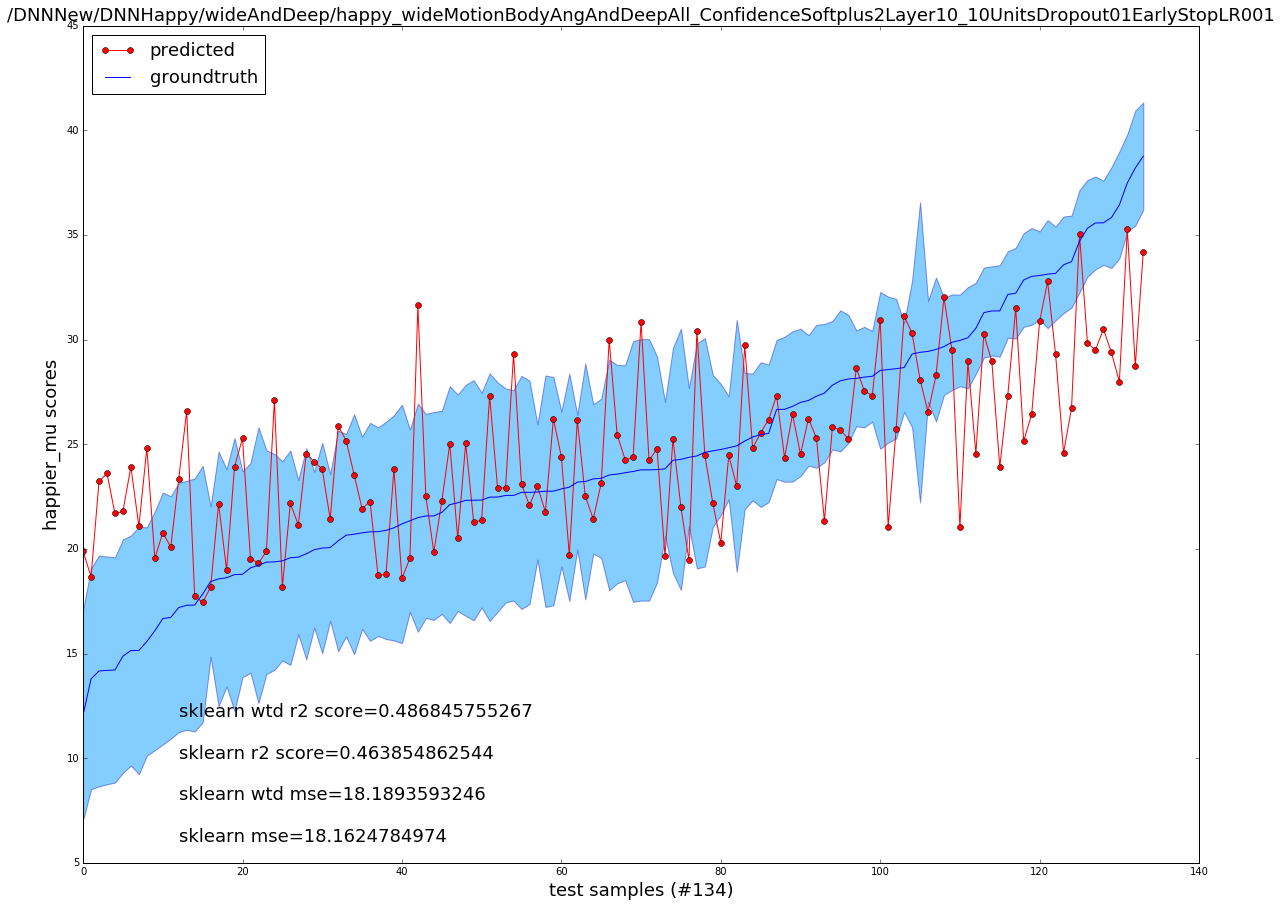

In [22]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted[predicted_name].size, 1)

plt.errorbar(x,y_all_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_sorted[LABEL].values-y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_sorted[LABEL].values+y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_sorted[LABEL].values,fmt='b',label="groundtruth")

plt.title(model_dir_name,fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(12,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
plt.text(12,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
plt.text(12,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
plt.text(12,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()
fig_name = model_dir_name + "/testPrediction.pdf"
ax.savefig(fig_name) 

In [23]:
predicted_name_train ="predicted_"+LABEL+"_train"
y_hat_train = pd.DataFrame(y_predicted_train, columns=[predicted_name_train], index=y_train[LABEL].index) 
y_all_train = pd.concat([y_hat_train, y_train[LABEL], y_train[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
y_all_sorted_train = y_all_train.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


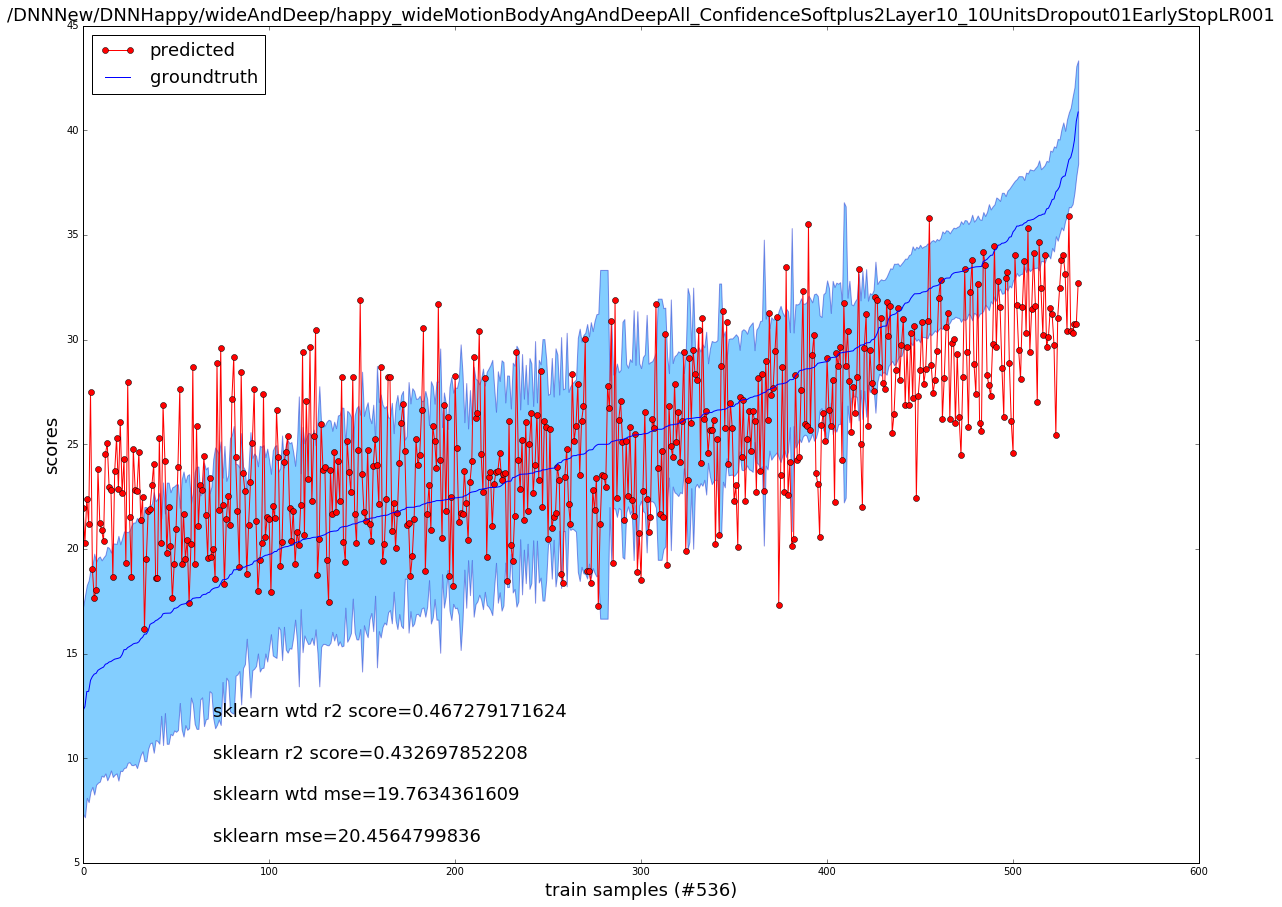

In [24]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train[predicted_name_train].size, 1)

plt.errorbar(x,y_all_sorted_train[predicted_name_train].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_sorted_train[LABEL].values-y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]], y_all_sorted_train[LABEL].values+y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_sorted_train[LABEL].values,fmt='b',label="groundtruth")

plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()
fig_name = model_dir_name + "/trainPrediction.pdf"
ax.savefig(fig_name) 

In [64]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [65]:
mapperLR = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True, sparse = True)


In [66]:

transformedDataLR = mapperLR.fit_transform(data.copy())

scores_WTS = pd.concat([scores, WTS_df], axis = 1)

X_trainLR, X_testLR, y_trainLR, y_testLR = model_selection.train_test_split(transformedDataLR, scores_WTS, test_size=0.2, random_state=42)

lr.fit(X_trainLR, y_trainLR[EMOSCORES[LABEL_ID]],sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])

ytest_pred_lr=lr.predict(X_testLR)
ytrain_pred_lr=lr.predict(X_trainLR)

In [67]:
print("Mean squared error LR wtd (test): %.2f"
      % metrics.mean_squared_error( y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]]))
# Explained variance score: 1 is perfect prediction
print('R2 score LR wtd (test): %.4f' % metrics.r2_score( y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]]))

Mean squared error LR wtd (test): 17.74
R2 score LR wtd (test): 0.4995


In [52]:
print("Mean squared error wtd LR (train): %.2f"
      % metrics.mean_squared_error( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]]))
# Explained variance score: 1 is perfect prediction
print('R2 score wtd LR (train): %.2f' % metrics.r2_score( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]]))

Mean squared error wtd LR (train): 19.81
R2 score wtd LR (train): 0.47


In [69]:
y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_testLR[LABEL].index) 

y_all_testlr = pd.concat([y_hat_lr, y_testLR[LABEL], y_testLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)

y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name_train], index=y_trainLR[LABEL].index) 

y_all_trainlr = pd.concat([ytrain_hat_lr, y_trainLR[LABEL], y_trainLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)

y_all_trainlr_sorted = y_all_trainlr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


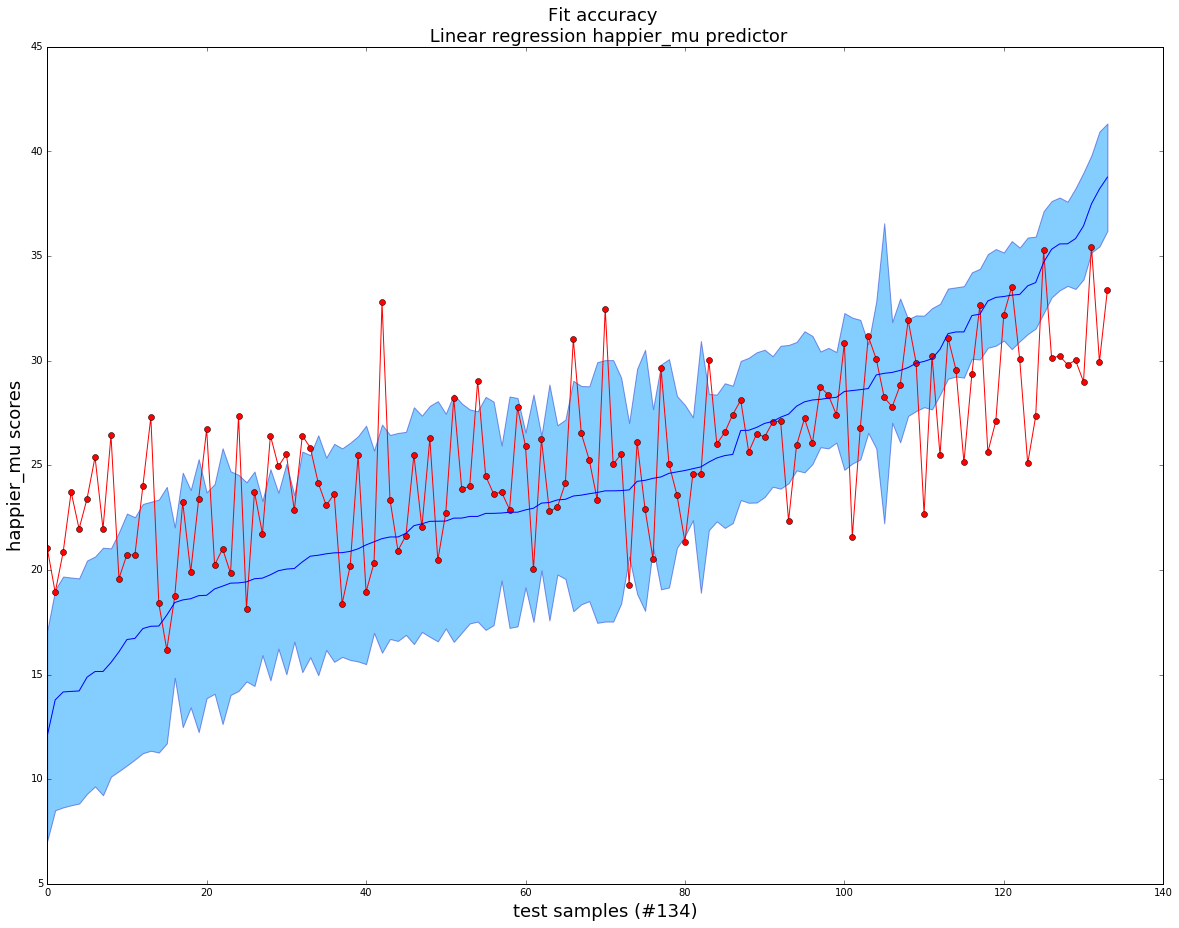

In [70]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()

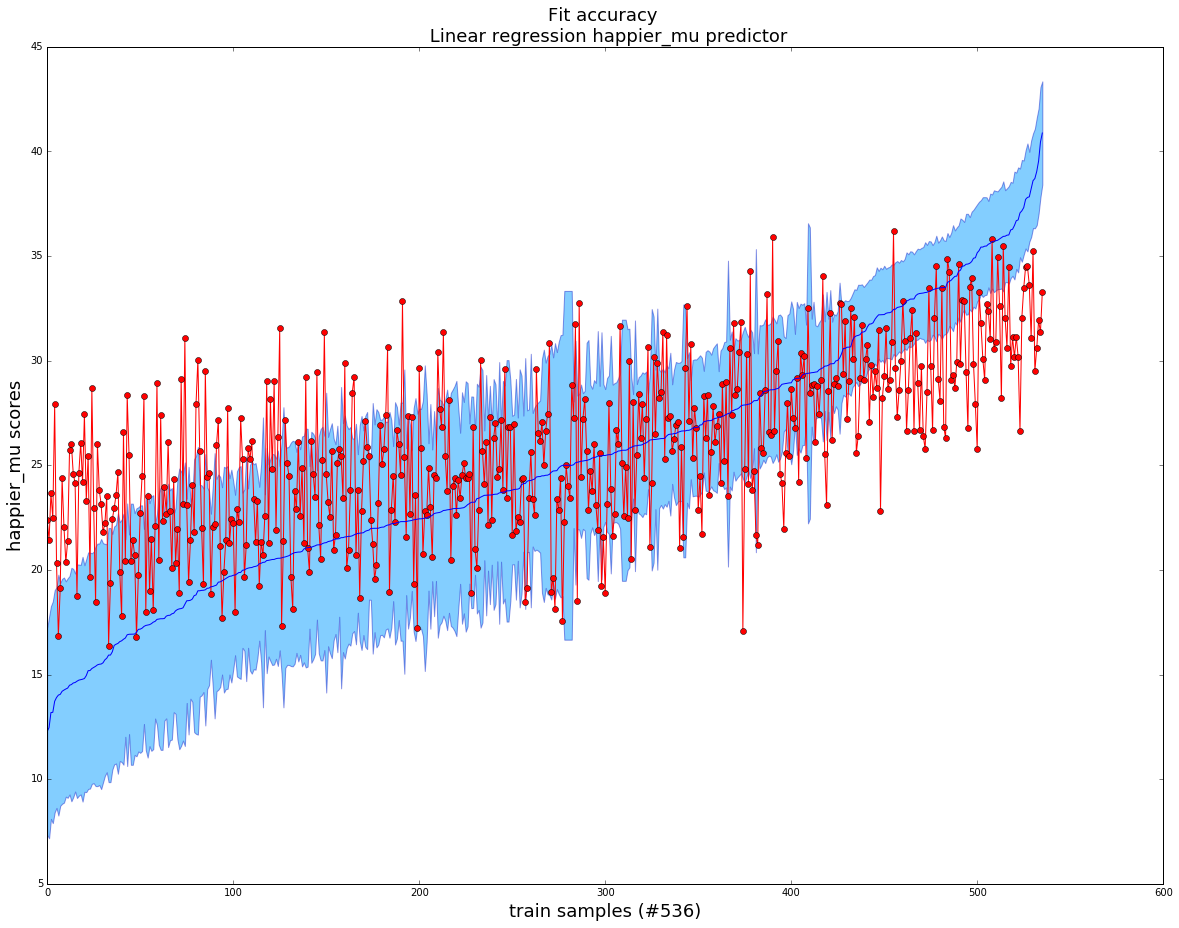

In [71]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainlr_sorted[predicted_name_train].size, 1)
plt.errorbar(x,y_all_trainlr_sorted[predicted_name_train].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [61]:
lr.coef_

array([-0.49739174,  0.43501176,  0.18048968, -0.49100797, -0.12632153,
        0.20959529, -0.1315793 ,  0.67025964,  1.12883121, -2.71626753,
       -2.43797512,  4.00135738,  0.48665989, -1.15766171, -3.02786202,
       -2.38324389, -0.6903216 ])